<a href="https://colab.research.google.com/github/Lxyyxxx/Colab/blob/main/REINFORCE_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install loguru

In [2]:
import tensorflow as tf
import gym
import matplotlib.pyplot as plt
from loguru import logger
from typing import Any

In [3]:
class REINFORCEModel(tf.keras.Model):
    def __init__(self, action_n: int) -> None:
        super().__init__()
        self.nn = [
            tf.keras.layers.Dense(30, activation='relu'),
            tf.keras.layers.Dense(30, activation='relu'),
            tf.keras.layers.Dense(action_n, activation='softmax'),
        ]

    def call(self, state: Any) -> Any:
        p = state
        for layer in self.nn:
            p = layer(p)
        return p

In [4]:
class BaselineModel(tf.keras.Model):
    def __init__(self, action_n: int) -> None:
        super().__init__()
        self.nn = [
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(action_n),
        ]

    def call(self, state: Any) -> Any:
        q = state
        for layer in self.nn:
            q = layer(q)
        return q

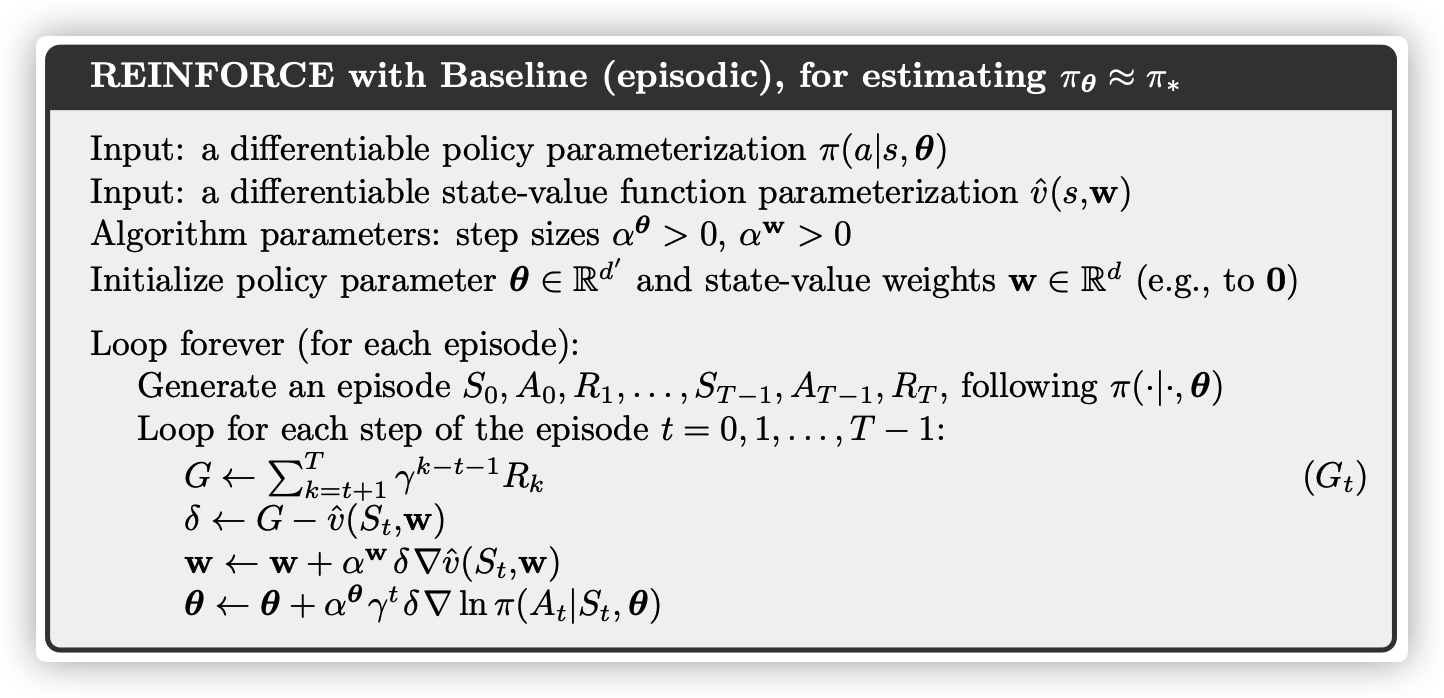

In [5]:
class REINFORCEAgent():
    def __init__(
        self,
        action_n: int,
        alpha_q: float = 0.1,
        alpha_p: float = 0.01,
        gamma: float = 0.9,
    ) -> None:
        self.action_n = action_n
        self.alpha_q = alpha_q
        self.alpha_p = alpha_p
        self.gamma = gamma
        self.model = REINFORCEModel(action_n)
        self.baseline = BaselineModel(action_n)

    def predict(self, state: Any) -> int:
        state = tf.expand_dims(tf.convert_to_tensor(state), 0)
        action = tf.argmax(self.model(state), axis=1).numpy()[0]
        return action

    def learn(self, t: int, state: Any, action: int, G: float) -> None:
        state = tf.expand_dims(tf.convert_to_tensor(state), 0)
        one_hot_actions = tf.one_hot([action], self.action_n)
        # baseline
        td_error = G - tf.reduce_sum(tf.multiply(one_hot_actions, self.baseline(state)), axis=1).numpy()
        with tf.GradientTape() as tape:
            q_loss = tf.reduce_sum(tf.multiply(one_hot_actions, self.baseline(state)), axis=1)
        q_grads = tape.gradient(q_loss, self.baseline.trainable_weights)
        for v, g in zip(self.baseline.trainable_weights, q_grads):
            v.assign_add(self.alpha_q * td_error * g)
        # reinforce
        with tf.GradientTape() as tape:
            policy = tf.reduce_sum(tf.multiply(one_hot_actions, self.model(state)), axis=1)
            p_loss = tf.math.log(policy)
        p_grads = tape.gradient(p_loss, self.model.trainable_weights)
        for v, g in zip(self.model.trainable_weights, p_grads):
            v.assign_add(self.alpha_p * self.gamma ** t * td_error * g)

    def update_target(self) -> None:
        self.target_model.set_weights(self.model.get_weights())

    def save_model(self) -> None:
        self.model.save('reinforce')

    def load_model(self) -> None:
        self.model = tf.keras.models.load_model('reinforce')

In [6]:
def run_episode(env: gym.Wrapper, agent: REINFORCEAgent, training: bool, render: bool = False) -> float:
    state = env.reset()
    done = False
    step = 0
    score = 0
    rewards = []
    states = []
    actions = []
    # trajectory
    while not done:
        if render:
            env.render()
        step += 1
        action = agent.predict(state)
        state_, reward, done, info = env.step(action)
        score += reward
        rewards.append(reward)
        states.append(state)
        actions.append(action)
        state = state_
    # update
    if training:
        T = len(rewards)
        for t, (s, a, r) in enumerate(zip(states, actions, rewards)):
            # G
            G = 0
            for k in range(t + 1, T + 1):
                G += agent.gamma ** (k-t-1) * rewards[k-1]
            # theta
            agent.learn(t, s, a, G)
    return score

In [7]:
def train(env: gym.Wrapper, agent: REINFORCEAgent) -> None:
    score_result = []
    max_score = 0
    for episode in range(1000):
        score = run_episode(env, agent, training=True)
        score_result.append(score)
        if score > max_score:
            max_score = score
            logger.info('Episode {}: Best score {}'.format(episode, score))
        if score == max_score:
            agent.save_model()
        if episode % 50 == 0:
            logger.info('Episode {}: score {}'.format(episode, score))

    plt.title('Train Score Curve')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.plot(score_result, label='$Score$')
    plt.legend()
    plt.show()


def play(env: gym.Wrapper, agent: REINFORCEAgent) -> None:
    score_result = []
    agent.load_model()
    for episode in range(5):
        score = run_episode(env, agent, training=False, render=False)
        score_result.append(score)
        logger.info('Round {}: score: {}'.format(episode, score))

    plt.title('Play Score Curve')
    plt.xlabel('Round')
    plt.ylabel('Score')
    plt.plot(score_result, label='$Score$')
    plt.legend()
    plt.show()

2021-10-03 04:30:21.181 | INFO     | __main__:train:9 - Episode 0: Best score 10.0


INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 04:30:21.745 | INFO     | __main__:train:13 - Episode 0: score 10.0


INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 04:30:24.774 | INFO     | __main__:train:9 - Episode 13: Best score 11.0


INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 04:30:29.078 | INFO     | __main__:train:13 - Episode 50: score 8.0


INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 04:30:30.319 | INFO     | __main__:train:9 - Episode 60: Best score 13.0


INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 04:30:31.339 | INFO     | __main__:train:9 - Episode 62: Best score 17.0


INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 04:30:31.890 | INFO     | __main__:train:9 - Episode 63: Best score 18.0


INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 04:30:33.119 | INFO     | __main__:train:9 - Episode 69: Best score 19.0


INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 04:30:34.233 | INFO     | __main__:train:9 - Episode 71: Best score 23.0


INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 04:30:34.866 | INFO     | __main__:train:9 - Episode 72: Best score 24.0


INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 04:30:35.647 | INFO     | __main__:train:9 - Episode 73: Best score 37.0


INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 04:30:36.645 | INFO     | __main__:train:9 - Episode 74: Best score 69.0


INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 04:30:45.150 | INFO     | __main__:train:13 - Episode 100: score 34.0
2021-10-03 04:30:48.081 | INFO     | __main__:train:9 - Episode 107: Best score 88.0


INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 04:30:49.649 | INFO     | __main__:train:9 - Episode 109: Best score 102.0


INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 04:31:07.576 | INFO     | __main__:train:13 - Episode 150: score 66.0
2021-10-03 04:31:16.502 | INFO     | __main__:train:9 - Episode 171: Best score 110.0


INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 04:31:28.811 | INFO     | __main__:train:13 - Episode 200: score 59.0
2021-10-03 04:31:35.668 | INFO     | __main__:train:9 - Episode 213: Best score 114.0


INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 04:31:54.324 | INFO     | __main__:train:9 - Episode 247: Best score 116.0


INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 04:31:55.671 | INFO     | __main__:train:13 - Episode 250: score 43.0
2021-10-03 04:32:18.791 | INFO     | __main__:train:13 - Episode 300: score 47.0
2021-10-03 04:32:40.668 | INFO     | __main__:train:13 - Episode 350: score 59.0
2021-10-03 04:33:03.345 | INFO     | __main__:train:9 - Episode 397: Best score 151.0


INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 04:33:05.507 | INFO     | __main__:train:13 - Episode 400: score 107.0
2021-10-03 04:33:26.958 | INFO     | __main__:train:13 - Episode 450: score 46.0
2021-10-03 04:33:48.838 | INFO     | __main__:train:13 - Episode 500: score 48.0
2021-10-03 04:34:12.237 | INFO     | __main__:train:13 - Episode 550: score 39.0
2021-10-03 04:34:34.805 | INFO     | __main__:train:13 - Episode 600: score 32.0
2021-10-03 04:34:59.570 | INFO     | __main__:train:13 - Episode 650: score 76.0
2021-10-03 04:35:24.295 | INFO     | __main__:train:13 - Episode 700: score 74.0
2021-10-03 04:35:44.311 | INFO     | __main__:train:13 - Episode 750: score 57.0
2021-10-03 04:36:07.467 | INFO     | __main__:train:13 - Episode 800: score 46.0
2021-10-03 04:36:12.965 | INFO     | __main__:train:9 - Episode 808: Best score 182.0


INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 04:36:35.064 | INFO     | __main__:train:13 - Episode 850: score 55.0
2021-10-03 04:36:51.804 | INFO     | __main__:train:9 - Episode 871: Best score 184.0


INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 04:37:08.249 | INFO     | __main__:train:13 - Episode 900: score 42.0
2021-10-03 04:37:35.264 | INFO     | __main__:train:13 - Episode 950: score 43.0


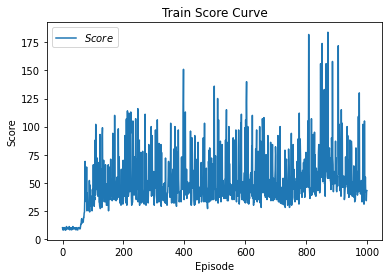

2021-10-03 04:37:57.757 | INFO     | __main__:play:29 - Round 0: score: 47.0
2021-10-03 04:37:57.825 | INFO     | __main__:play:29 - Round 1: score: 75.0
2021-10-03 04:37:57.881 | INFO     | __main__:play:29 - Round 2: score: 57.0
2021-10-03 04:37:57.946 | INFO     | __main__:play:29 - Round 3: score: 65.0
2021-10-03 04:37:58.039 | INFO     | __main__:play:29 - Round 4: score: 101.0


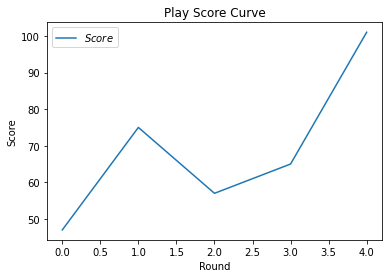

In [8]:
if __name__ == '__main__':
    env = gym.make('CartPole-v0')
    agent = REINFORCEAgent(env.action_space.n)
    # train
    train(env, agent)
    # play
    play(env, agent)